# Imports

In [1]:
%%capture
# Import helper functions
!wget https://raw.githubusercontent.com/daoterog/Solid_Domestic_Waste_Image_Classification/main/file_management.py
!wget https://raw.githubusercontent.com/daoterog/Solid_Domestic_Waste_Image_Classification/main/evaluation_functions.py
!wget https://raw.githubusercontent.com/daoterog/Solid_Domestic_Waste_Image_Classification/main/image_processing.py

In [22]:
import os
import errno

import numpy as np
import pandas as pd
from random import sample

import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression

from file_management import bring_data, walk_through_dir, storeresults, copytree
from image_processing import (load_images, get_visual_dictionary, get_histogram,
                              applypca, applynmf)
from evaluation_functions import (hyperparametertunning, learningcurve, 
                                  plotlearningcurve, CV)

from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


# Preprocessing 

## Load the Data

In [3]:
path_list = ['/content/drive/MyDrive/PI2/data/cardboard.zip',
            '/content/drive/MyDrive/PI2/data/metal.zip']

# Unzip the data
bring_data(path_list=path_list)

# How many images/classes are there?
walk_through_dir("data")

Not found
There are 2 directories and 0 images in 'data'.
There are 0 directories and 403 images in 'data/cardboard'.
There are 0 directories and 410 images in 'data/metal'.


## Run Preprocessing Functions


In [4]:
# Preprocessing
dims = (75, 75)
grayscale = True
blur = True
rescale = False
center = True
edges = False

# BoF
patch_size, step_size = 10,3

In [5]:
# Load images
image_dict = load_images(resize = dims, grayscale = grayscale, blur =  blur, 
                         rescale = rescale, center = center, edges = edges)
image_list = []
labels = []
for key, value in image_dict.items():
    image_list.extend(value)
    cat = [key]*len(value)
    labels.append(cat)

# # Balancing dataset randomly
n = 403
cont = 0
balanced_image_list = []
balanced_label_list = []
for values in image_dict.values():
    images = sample(values, n)
    balanced_image_list.extend(images)
    label = [cont]*n
    balanced_label_list.extend(label)
    cont += 1

# Flattening
X = []

for img in balanced_image_list:
    dims = img.shape
    image = np.reshape(img, (1, dims[0]*dims[1]))[0]
    X.append(image)

X = pd.DataFrame(X)
y = pd.DataFrame(balanced_label_list)

## Bag of Features

In [6]:
# Bag of Features
vdict = get_visual_dictionary(balanced_image_list, patch_size, step_size, 60)
Xh = [get_histogram(img, patch_size, step_size, vdict) \
      for img in balanced_image_list]
Xh = np.array(Xh)

Xh = pd.DataFrame(Xh)
Xh.fillna(0, inplace = True)

## Print first n Images

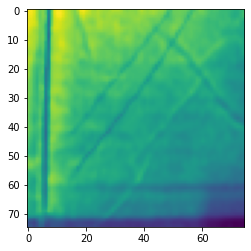

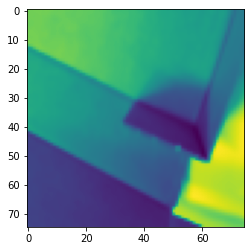

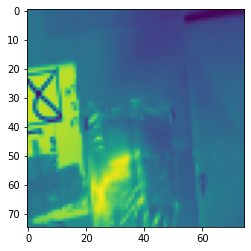

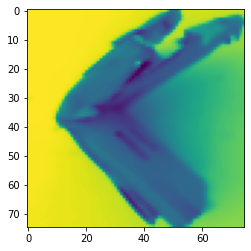

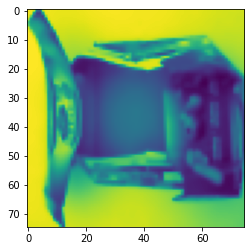

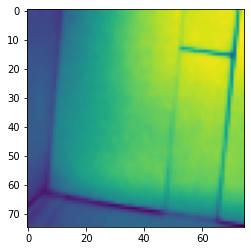

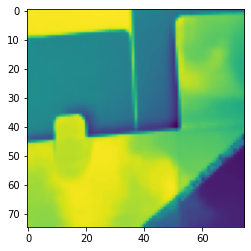

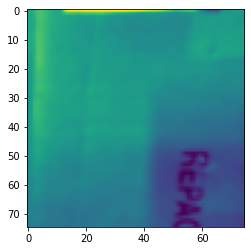

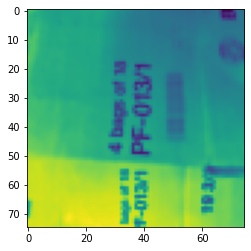

In [9]:
n = 10

for img in balanced_image_list[1:n]:
    plt.imshow(img)
    plt.show()

## Run Dimenion Reduction

In [12]:
X_pca, pca = applypca(X)

variance = pca.explained_variance_ratio_

suma = 0
cont = 0
while suma < 0.8:
  suma += variance[cont]
  cont += 1

X_pca80 = X_pca.iloc[:,:cont]

Xh_pca, pca = applypca(Xh) 

variance = pca.explained_variance_ratio_

suma = 0
cont = 0
while suma < 0.8:
  suma += variance[cont]
  cont += 1

Xh_pca80 = Xh_pca.iloc[:,:cont]

X_nmf, nmf = applynmf(X, cont)
Xh_nmf, nmf = applynmf(Xh, cont)

print("Original X shape:",X.shape)
print("PCA Shape:",X_pca.shape)
print("PCA80 Shape",X_pca80.shape)
print("NMF Shape",X_nmf.shape,"\n")
print("Original BoF shape:",Xh.shape)
print("BoF PCA shape:",Xh_pca.shape)
print("BoF PCA80 shape",Xh_pca80.shape)
print("BoF NMF shape",Xh_nmf.shape)

Original X shape: (806, 5625)
PCA Shape: (806, 806)
PCA80 Shape (806, 29)
NMF Shape (806, 10) 

Original BoF shape: (806, 60)
BoF PCA shape: (806, 60)
BoF PCA80 shape (806, 10)
BoF NMF shape (806, 10)


# Model Evaluation

In [16]:
# Create Directory
root = 'experiments/'
destination = '/content/drive/MyDrive/sdw_classification/experiments/KNN'

try:
    os.mkdir(root)
except OSError as e:
    if e.errno == errno.EEXIST:
        print('Directory already exist')
    else:
        raise

# Create Experiment Directory
experiment = str(input('Type Experiment Name: '))
path = root + experiment
try:
    os.mkdir(path)
except OSError as e:
    if e.errno == errno.EEXIST:
        print('Directory already exist')
    else:
        raise
model_name = str(input('Type Model Name: '))

# Create training dictionary
X_dict = {'Regular':X,'PCA':X_pca,'PCA80':X_pca80,'NMF':X_nmf,'BoF':Xh,
          'BoF-PCA':Xh_pca,'BoF-PCA80':Xh_pca80,'BoF-NMF':Xh_nmf}

Type Experiment Name: Prueba
Type Model Name: Logistic_Regression


## Hyperparameter Tunning

In [21]:
%%capture

# Classifier
model = LogisticRegression()

# Create parameter grid
penalty = ['l1','l2','elasticnet','none']
C = np.logspace(0,4,10)
hyperparameters = dict(C = C,penalty = penalty)

# Tune Hyperparameters
param_dict, param_title_dictionary = hyperparametertunning(model, X_dict, y, 
                                                           hyperparameters, 5, 
                                                           'precision')

## Learning Curves

In [23]:
%%capture
(train_sizes_dict, train_scores_mean_dict, train_scores_std_dict,
  test_scores_mean_dict, 
  test_scores_std_dict) = learningcurve(model, X_dict, y, 
                                        5, param_dict, 'precision', 
                                        np.linspace(0.1,1,50))

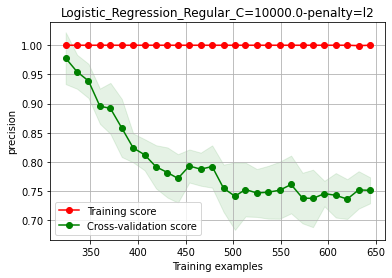

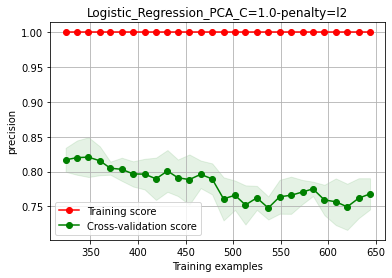

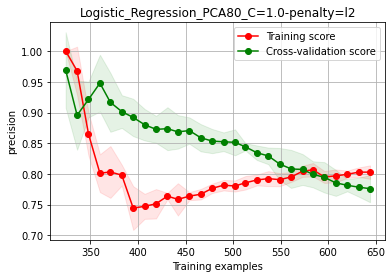

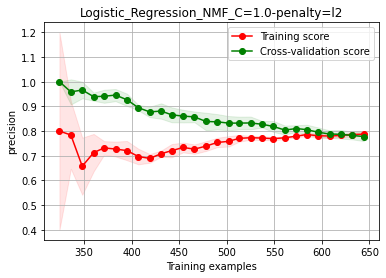

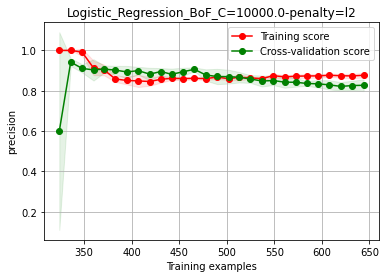

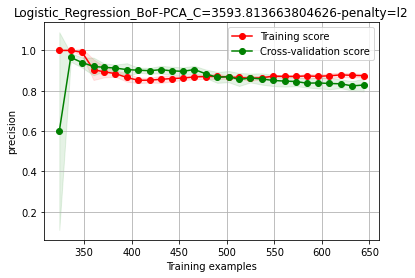

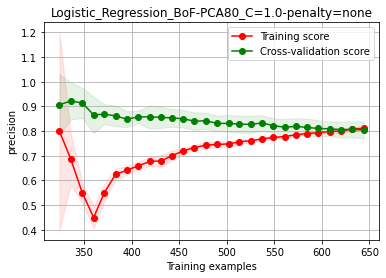

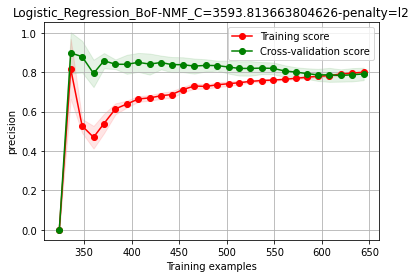

In [24]:
plotlearningcurve(model_name, param_dict, param_title_dictionary, 'precision', 
                  train_sizes_dict, train_scores_mean_dict, 
                  train_scores_std_dict, test_scores_mean_dict,
                  test_scores_std_dict, path)

## Cross-Validation

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example

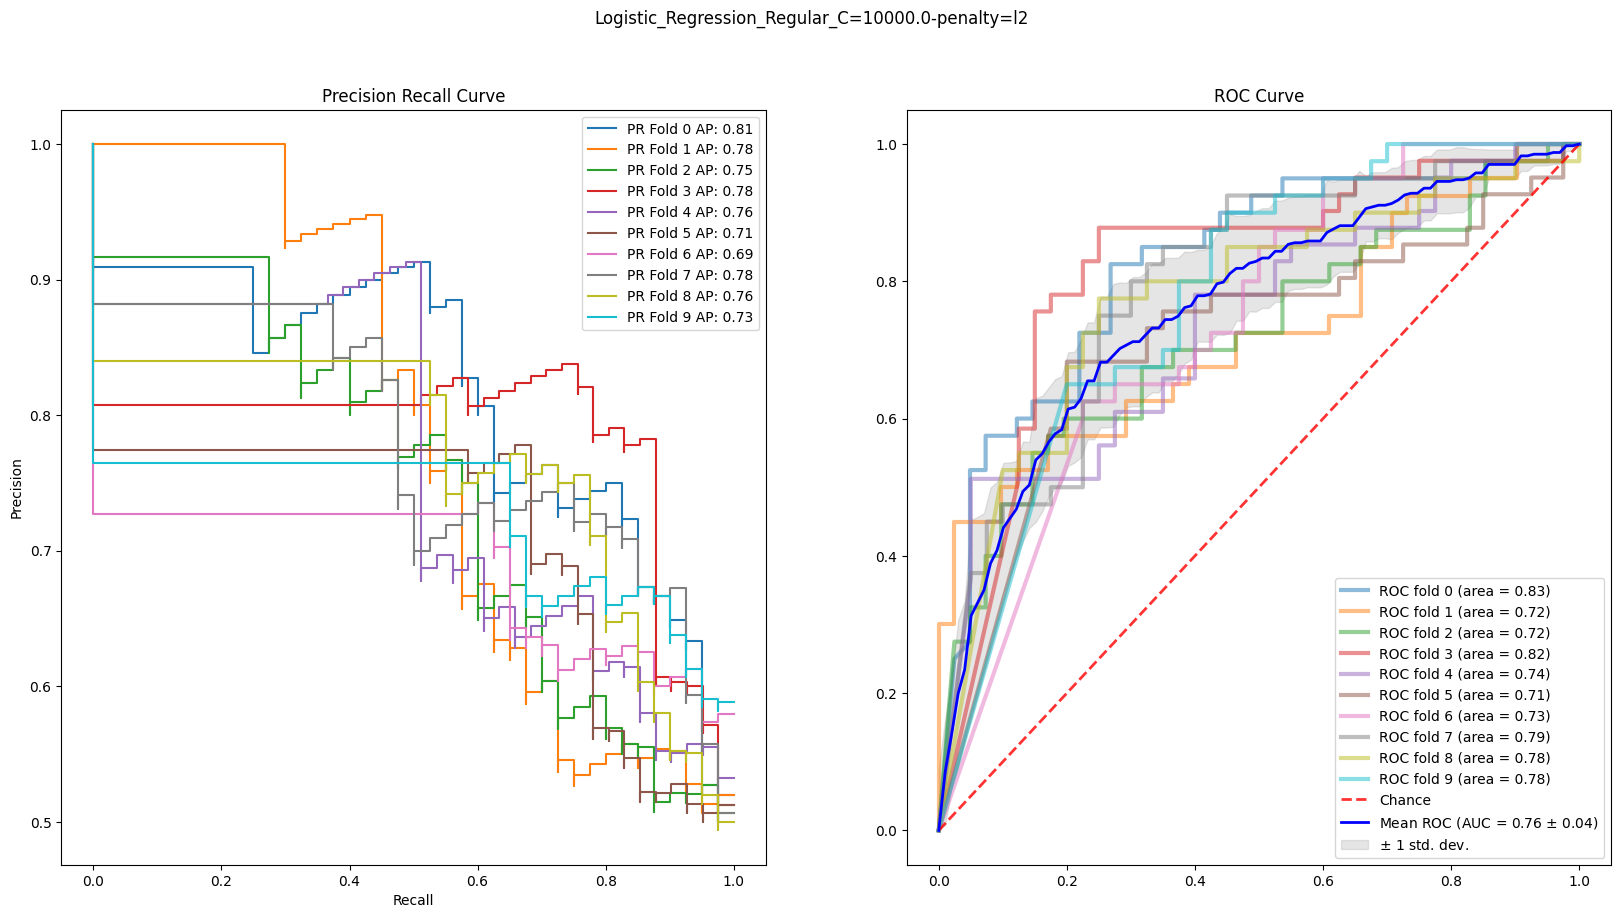

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example

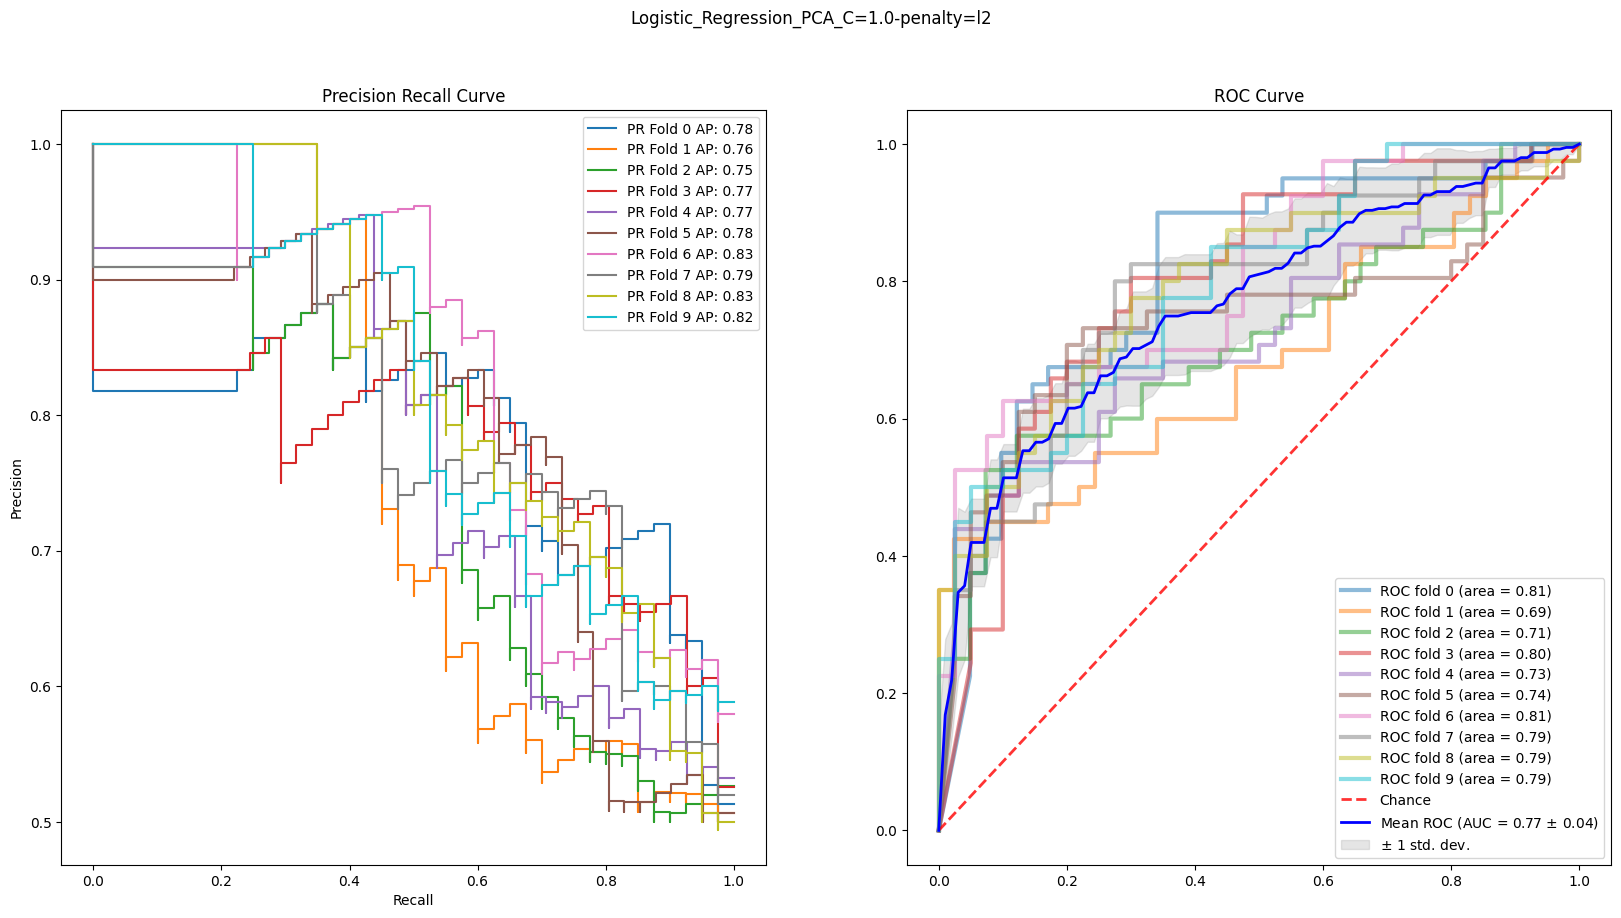

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

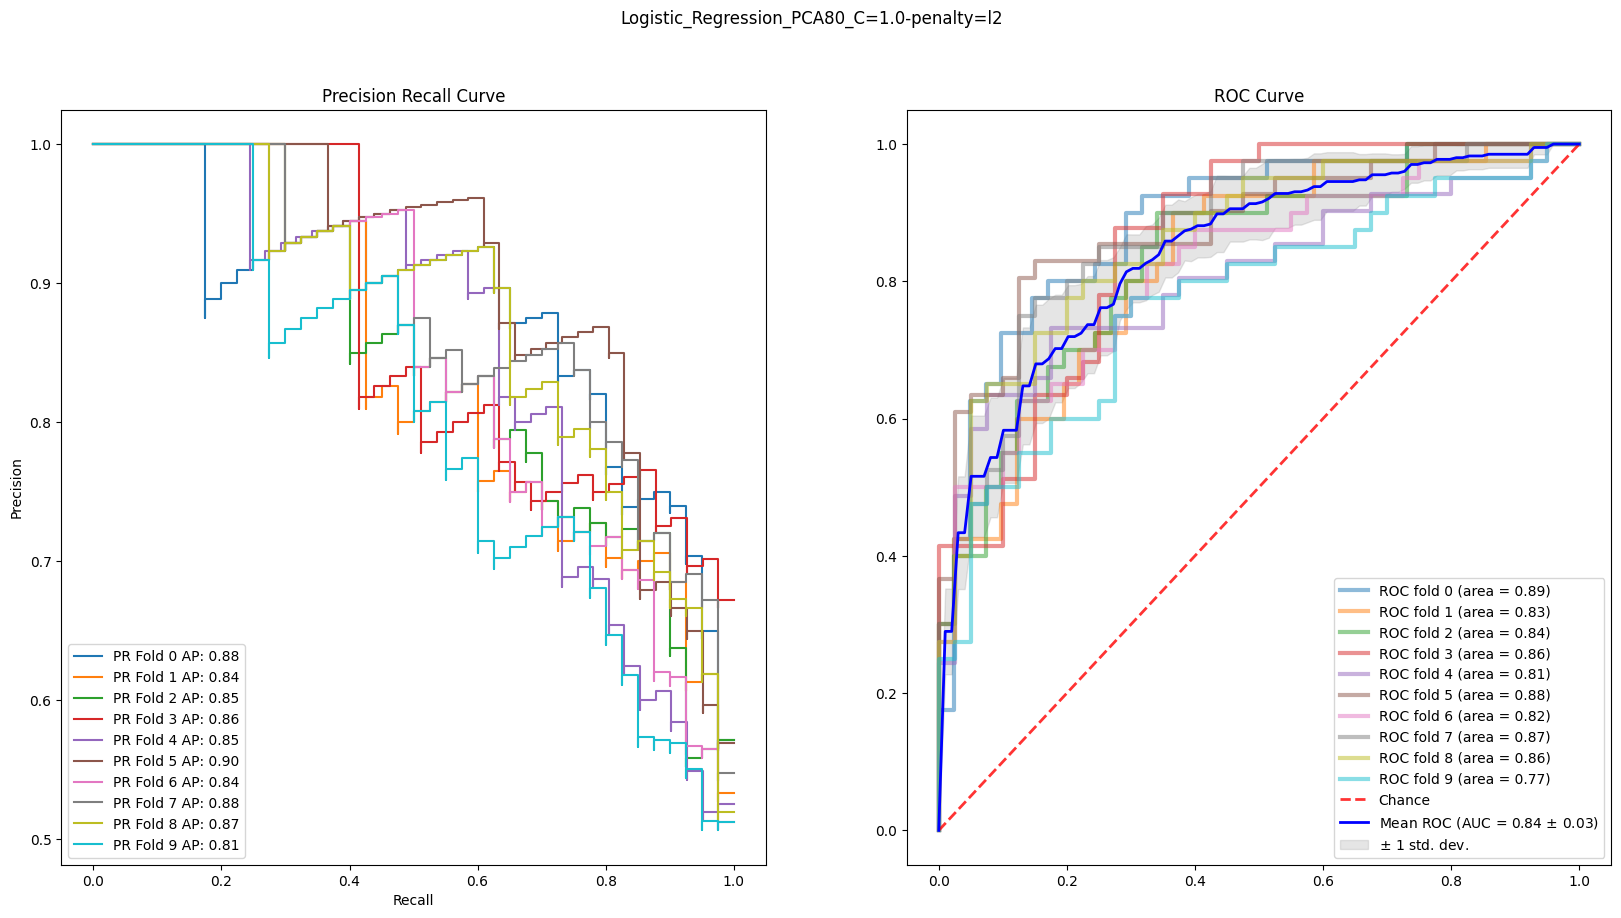

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

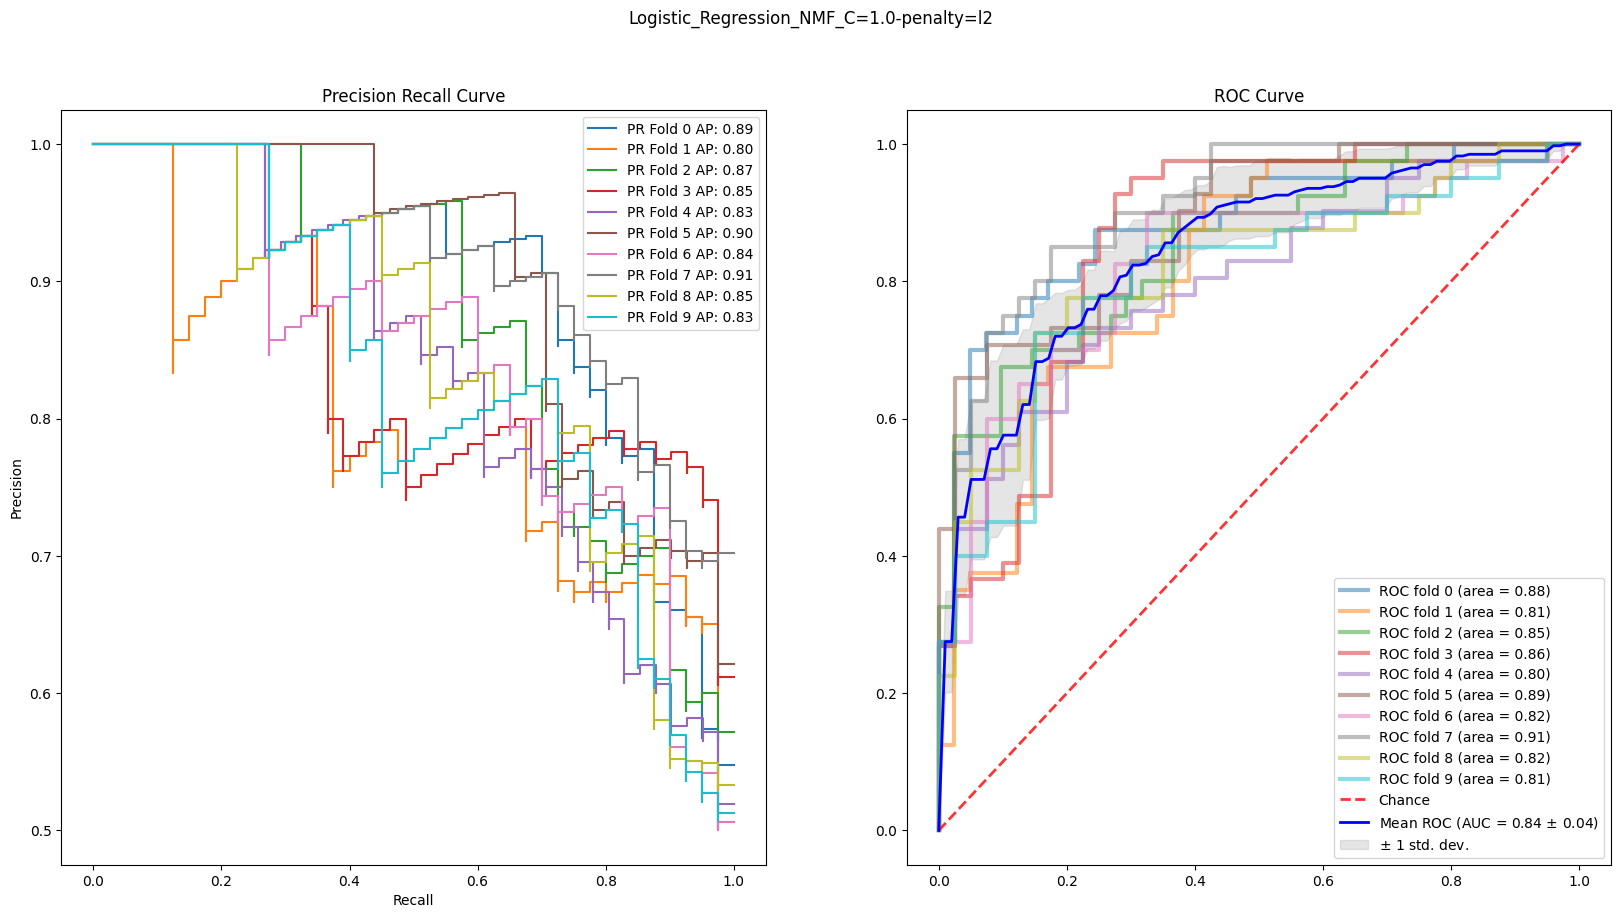

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example

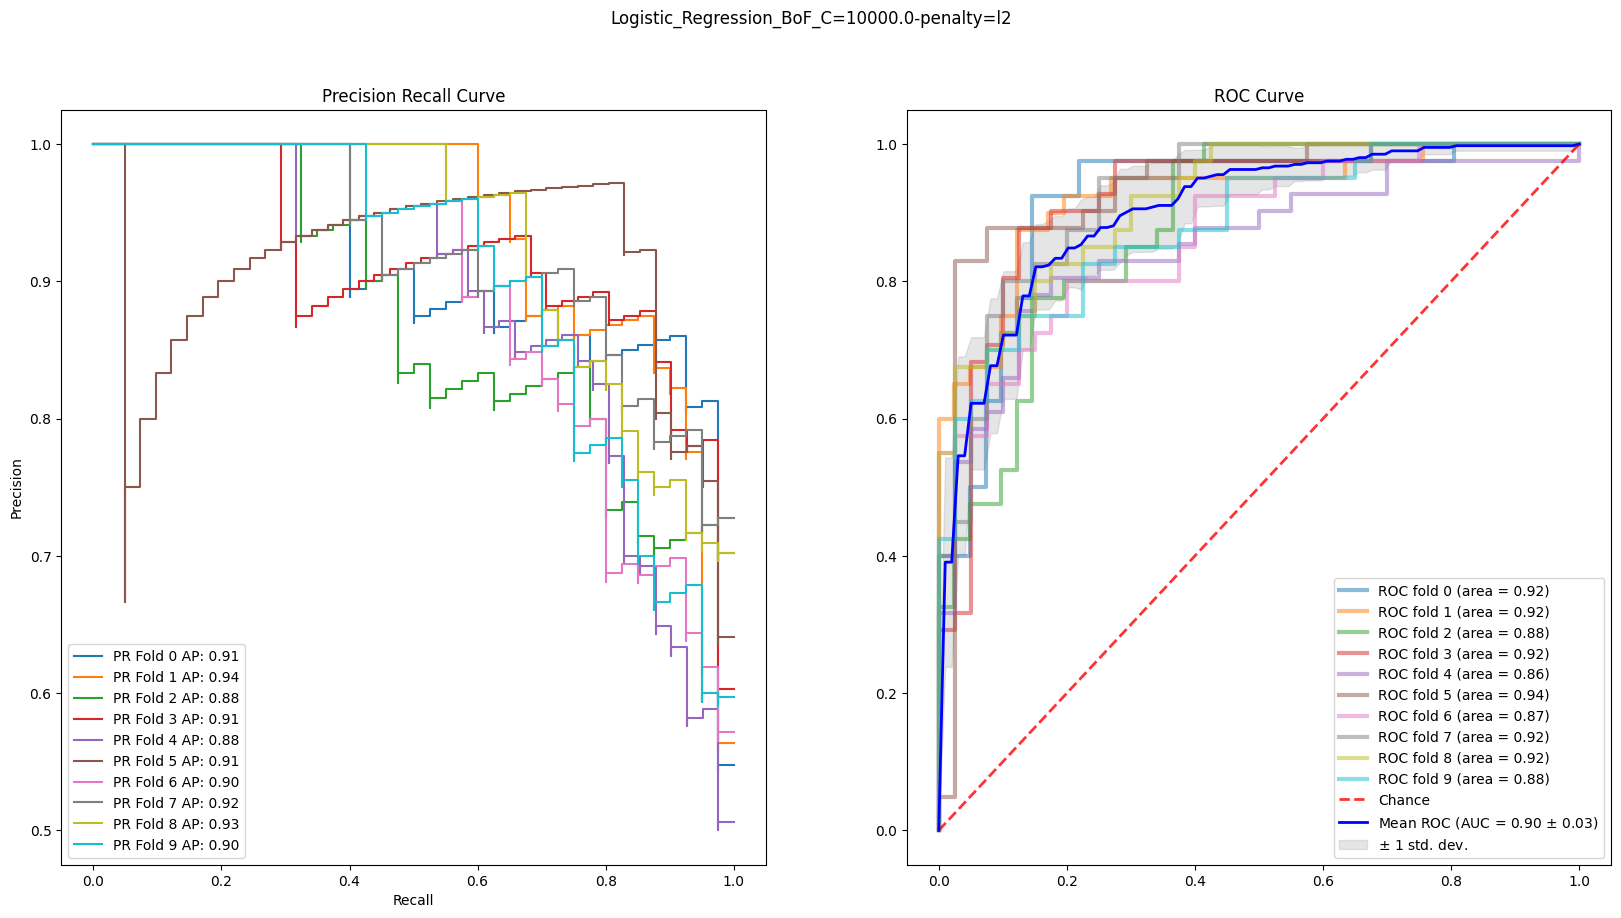

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example

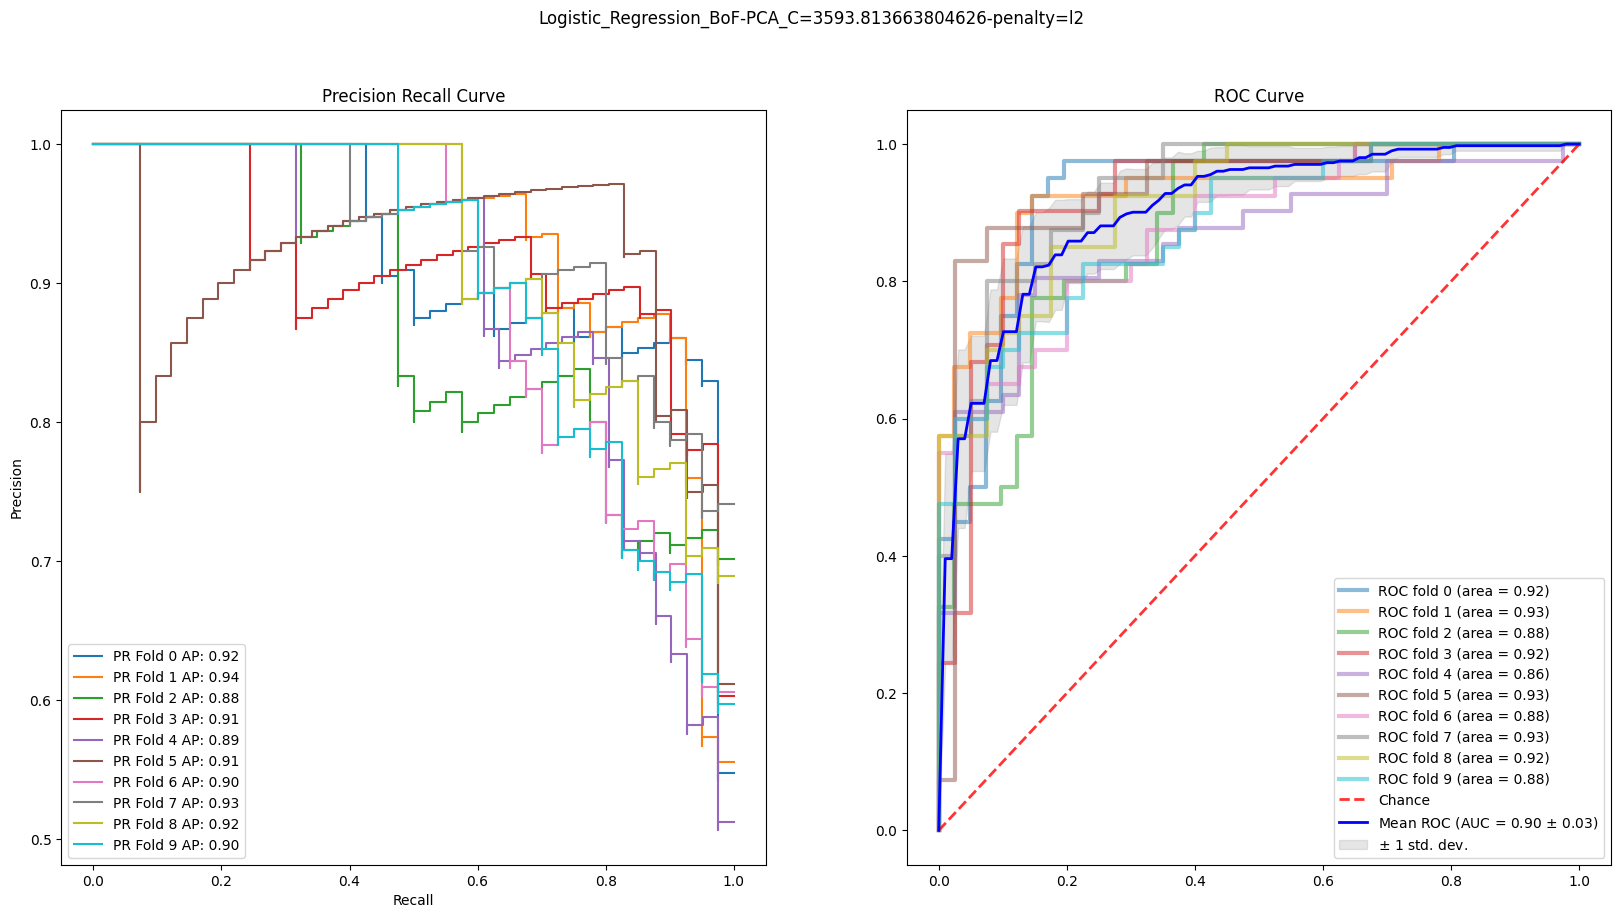

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

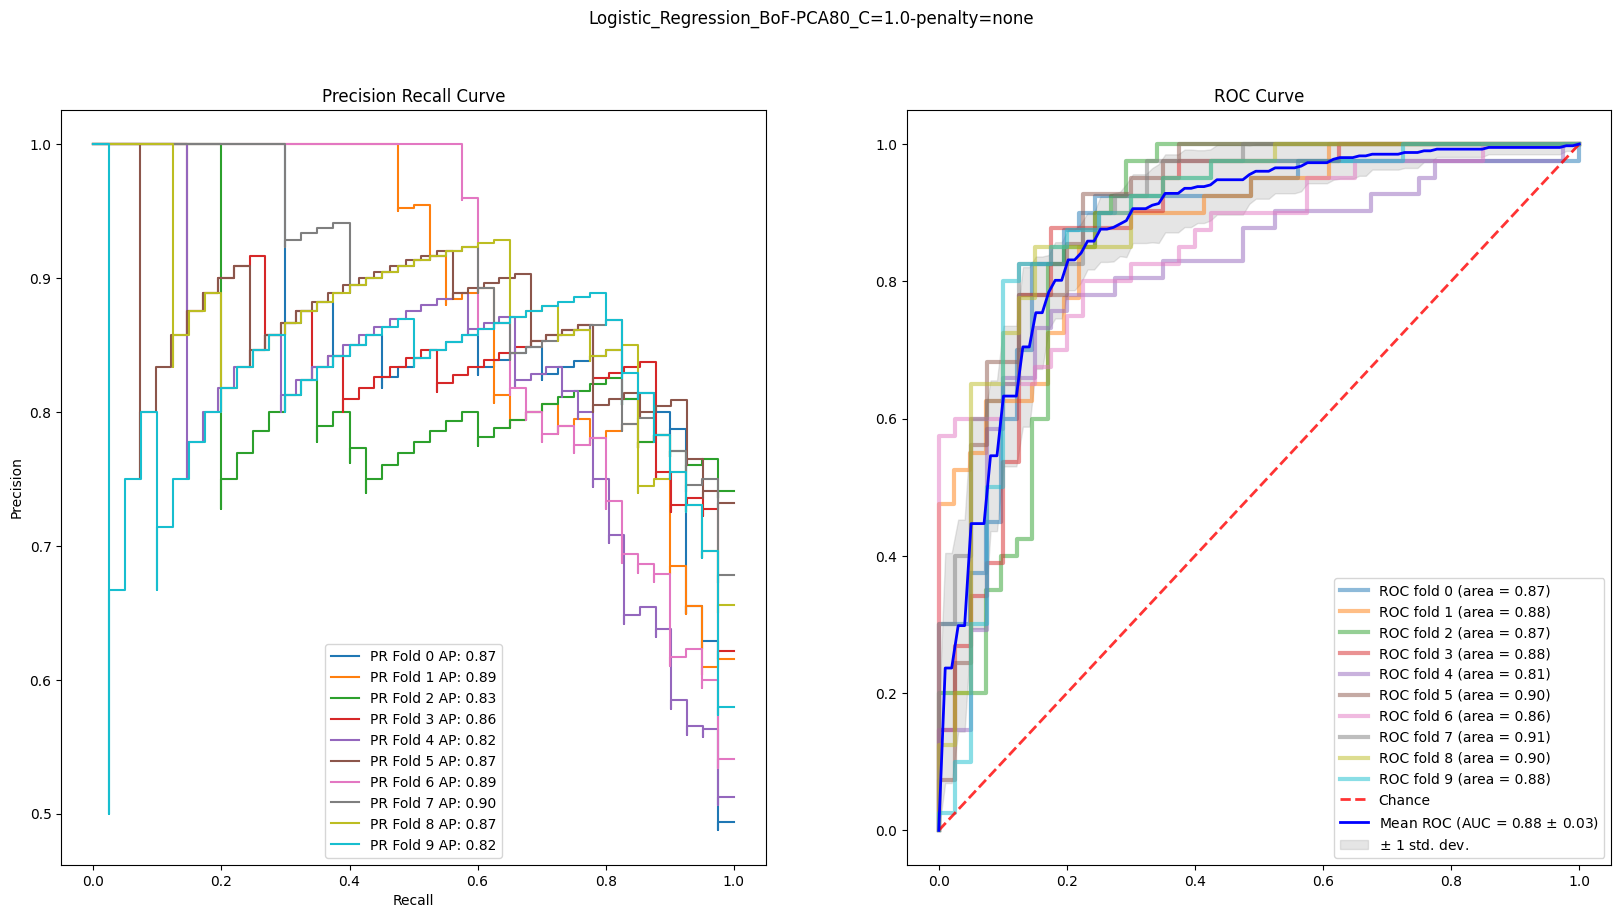

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

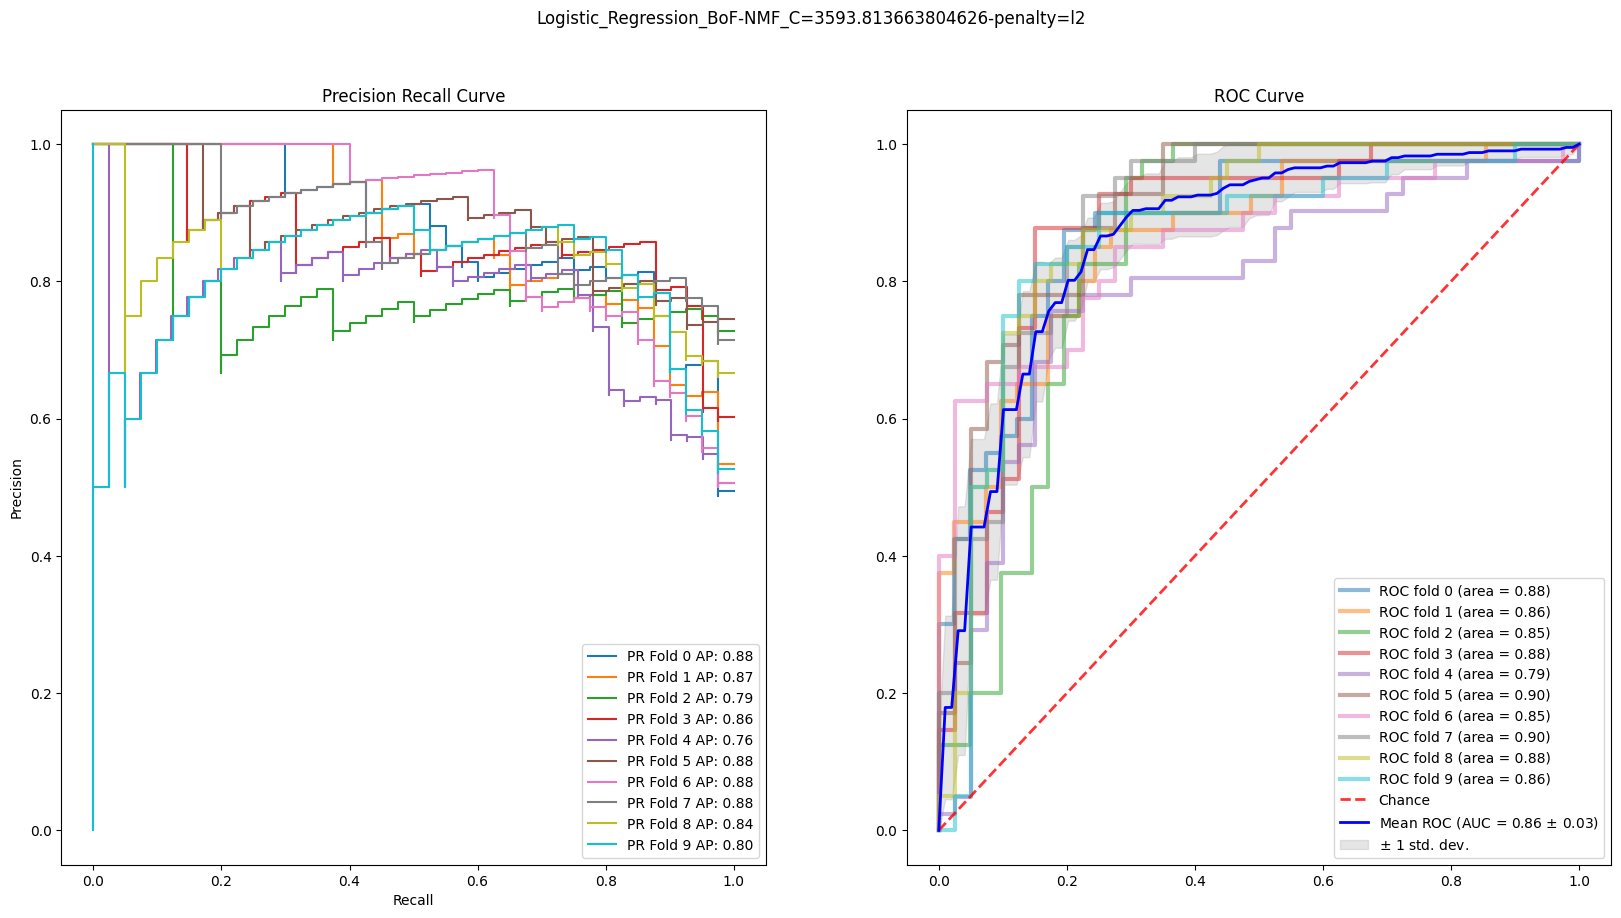

In [25]:
(precision_dict, recall_dict, f1_dict, auc_dict) = CV(model, X_dict, y, 
                                                      10, param_dict, 
                                                      param_title_dictionary, 
                                                      model_name, path)

## Other Results

In [27]:
results = [precision_dict, recall_dict, f1_dict, auc_dict]
df = storeresults(model, results, model_name, param_dict, param_title_dictionary, X, y, path)

df

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example

,Model,Dataset,Mean_Precision,STD_Precision,Mean_Recall,STD_Recall,Mean_F1,STD_F1,Mean_AUC,STD_AUC
1,Logistic_Regression_C=10000.0-penalty=l2,Regular,0.735159,0.0400165,0.652317,0.0730939,0.689347,0.0511972,0.761994,0.0393263
2,Logistic_Regression_C=1.0-penalty=l2,PCA,0.776399,0.0388822,0.587988,0.056645,0.667264,0.0400717,0.765768,0.0417537
3,Logistic_Regression_C=1.0-penalty=l2,PCA80,0.777665,0.0466542,0.724329,0.051562,0.749195,0.0416801,0.842866,0.0340614
4,Logistic_Regression_C=1.0-penalty=l2,NMF,0.781359,0.0482187,0.746951,0.0325783,0.762366,0.0241685,0.845396,0.0361979
5,Logistic_Regression_C=10000.0-penalty=l2,BoF,0.831969,0.0361581,0.806098,0.0818265,0.815651,0.0423099,0.903476,0.0259014
6,Logistic_Regression_C=3593.813663804626-penalt...,BoF-PCA,0.83058,0.0309997,0.816098,0.0731342,0.820996,0.038686,0.905695,0.0253353
7,Logistic_Regression_C=1.0-penalty=none,BoF-PCA80,0.807992,0.0459871,0.831037,0.0525371,0.817948,0.0372267,0.876817,0.0250215
8,Logistic_Regression_C=3593.813663804626-penalt...,BoF-NMF,0.791397,0.0425256,0.823659,0.0566987,0.805458,0.0357162,0.864617,0.0307109


## Storing Results


In [28]:
file_name = str(input('Enter the filename: '))
comment = str(input('Enter the experiment description:'))

df.to_csv(os.path.join(path,file_name + '.csv'))

np.savetxt(os.path.join(path,file_name + '.txt'),[comment], fmt = '%10s')

copytree(experiment,path,destination)

Enter the filename: prueba
Enter the experiment description:desc
